<a href="https://colab.research.google.com/github/UmarIgan/timeseries-notebooks/blob/main/glounts_hello.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gluonts
!pip install mxnet
!pip install pandas

     |████████████████████████████████| 2.8 MB 12.3 MB/s 
     |████████████████████████████████| 10.9 MB 38.9 MB/s 
     |████████████████████████████████| 47.3 MB 1.5 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


## Hello world gluonts
See https://www.microprediction.com/blog/popular-timeseries-packages for more packages

In [11]:
from gluonts.model import deepar
from gluonts.mx.trainer import Trainer
from gluonts.dataset import common
from gluonts.dataset.util import to_pandas
from gluonts.evaluation.backtest import make_evaluation_predictions
import pandas as pd
import requests
from itertools import islice
from dateutil.relativedelta import  *
from datetime import date, timedelta
import json
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


In [4]:
def load_bitcoin(period=180):
    coindeskURL = 'https://api.coindesk.com/v1/bpi/historical/close.json?'
    end = date.today()
    start = end - timedelta(days=period)
    url = f'{coindeskURL}start={start:%Y-%m-%d}&end={end:%Y-%m-%d}'
    result = requests.get(url)
    data=json.loads(result.content)['bpi']
    df_bpi=pd.DataFrame(data, index=[0]).T
    df_bpi=df_bpi.reset_index()
    df_bpi.columns=['date', 'value']
    df_bpi.sort_values(by='date')
    df_bpi['date']=pd.to_datetime(df_bpi['date'])
    df_bpi.set_index('date', inplace=True)
    return df_bpi
df_bitcoin=load_bitcoin(period=4000)

In [5]:
training_data = common.ListDataset([{
    "start": df_bitcoin.index[0],
    "target": df_bitcoin.value[:'2019-07-27']
}], freq='D')

trainer = Trainer(epochs=10)
estimator = deepar.DeepAREstimator(prediction_length=100, trainer=trainer,
                                   freq='D')
predictor = estimator.train(training_data=training_data)
#prediction = next(predictor.predict(data))
#print(prediction.mean)
#prediction.plot(output_file='graph.png')

100%|██████████| 50/50 [00:14<00:00,  3.42it/s, epoch=10/10, avg_epoch_loss=4.23]


In [9]:
test_data = common.ListDataset(
    [ {"start": df_bitcoin.index[0], "target": df_bitcoin.value[:'2021-07-27']},
     {"start": df_bitcoin.index[0], "target": df_bitcoin.value[:'2022-04-20']}],
    freq = "D"
)

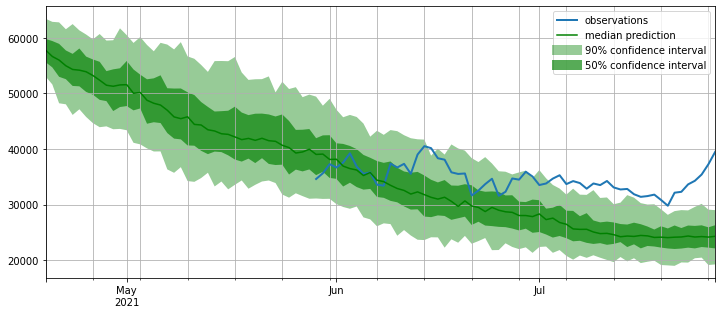

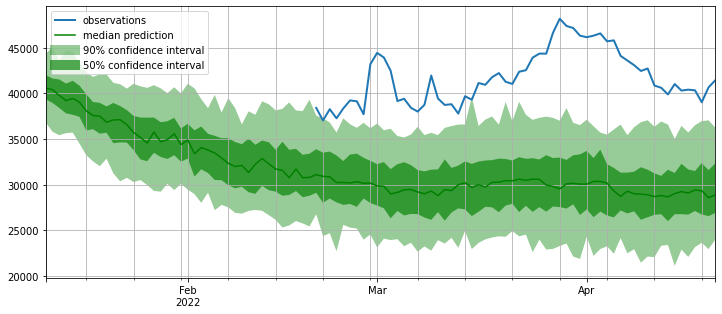

In [12]:
def plot_forecasts(tss, forecasts, past_length, num_plots):
    for target, forecast in islice(zip(tss, forecasts), num_plots):
        ax = target[-past_length:].plot(figsize=(12, 5), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        plt.show()

forecast_it, ts_it = make_evaluation_predictions(test_data, predictor=predictor)
forecasts = list(forecast_it)
tss = list(ts_it)
plot_forecasts(tss, forecasts, past_length=60, num_plots=3)

In [13]:
from gluonts.evaluation import Evaluator

evaluator = Evaluator(quantiles=[0.5])

agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))

agg_metrics

Running evaluation: 100%|██████████| 2/2 [00:00<00:00, 78.10it/s]


{'Coverage[0.5]': 0.125,
 'MAE_Coverage': 0.375,
 'MAPE': 0.1850221872329712,
 'MASE': 41.915758014739424,
 'MSE': 74379704.32000001,
 'MSIS': 377.7869359623412,
 'ND': 0.18463737050472712,
 'NRMSE': 0.21058814551659874,
 'OWA': nan,
 'QuantileLoss[0.5]': 1512317.333984375,
 'RMSE': 8624.366893865312,
 'abs_error': 1512317.25,
 'abs_target_mean': 40953.715,
 'abs_target_sum': 8190743.0,
 'mean_absolute_QuantileLoss': 1512317.333984375,
 'mean_wQuantileLoss': 0.18463738075829933,
 'sMAPE': 0.21006669521331786,
 'seasonal_error': 179.30021256946446,
 'wQuantileLoss[0.5]': 0.18463738075829933}